<a href="https://colab.research.google.com/github/ZoyPan1111/Tibame-Group-Project2021/blob/main/%E5%96%AE%E4%B8%80%E6%A8%A1%E5%9E%8B%E5%8F%83%E6%95%B8%E8%AA%BF%E6%95%B4%E6%AF%94%E8%BC%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 解壓縮狗便便照片

In [ ]:
import zipfile
f1 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_1.zip")
f1.extractall()
f2 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_2.zip")
f2.extractall()
f3 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_3.zip")
f3.extractall()
f4 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_6.zip")
f4.extractall()
f5 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_4.zip")
f5.extractall()
f6 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_5.zip")
f6.extractall()
f7 = zipfile.ZipFile("/content/drive/MyDrive/test_img/train_no.zip")
f7.extractall()

# import 套件

In [ ]:
import glob
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# 讀取照片路徑及分訓練集與測試集(不隨機分，固定)

In [ ]:
poos_re = glob.glob("train_1/poo_p*")
for i in range(2,7):
  temp = glob.glob(f"train_{i}/poo_p*")
  poos_re += temp
poos_no = glob.glob("train_no/nopoo_p*")
df1 = pd.DataFrame({
    "path":poos_re + poos_no,
    "ans":[0] * len(poos_re) + [1] * len(poos_no)
})
# print(len(poos_re)) 正常:1127
# print(len(poos_no)) 不正常:100

In [ ]:
x1 = np.array(df1["path"])
y1 = np.array(df1["ans"])

poos_rex = x1[y1 == 0]
poos_nox = x1[y1 == 1]

# 固定分訓練集與測試集(不隨機)
poos_rex_trian, poos_rex_test = train_test_split(poos_rex, test_size=0.1, random_state = 42)
poos_nox_trian, poos_nox_test = train_test_split(poos_nox, test_size=0.1, random_state = 42)

x_train = np.concatenate((poos_rex_trian, poos_nox_trian))
y_train = np.array([0] * len(poos_rex_trian) + [1] * len(poos_nox_trian))
x_test = np.concatenate((poos_rex_test, poos_nox_test))
y_test = np.array([0] * len(poos_rex_test) + [1] * len(poos_nox_test))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1104,)
(123,)
(1104,)
(123,)


# 遷移學習 - Use VGG16

## 取 VGG16 cnn (鎖住卷積模型)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preinput
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization

cnn_VGG = VGG16(include_top=False, input_shape=(224, 224, 3))  # include_top=False 不用VGG的mlp
cnn_VGG.summary()

# 卷積模型不參與訓練，要在 compile 前設定好
for l in cnn_VGG.layers:
  l.trainable = False

## VGGcnn + Layer

In [ ]:
# VGG16 model.v1
layers = [
    BatchNormalization(), # 訓練前將拿來使用的卷積模型先做標準化及優化處理
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")       
]

# model_vgg1 = Sequential(cnn_VGG.layers + layers)
# model_vgg1.summary()
# model_vgg2_1 = Sequential(cnn_VGG.layers + layers)
# model_vgg2_2 = Sequential(cnn_VGG.layers + layers)
# model_vgg2_3 = Sequential(cnn_VGG.layers + layers)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## model.compile loss函數與加速器

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# model_vgg1.compile(loss=SparseCategoricalCrossentropy(),
#               optimizer="adam",
#               metrics=["accuracy"])
# model_vgg2_1.compile(loss=SparseCategoricalCrossentropy(),
#               optimizer="adam",
#               metrics=["accuracy"])
# model_vgg2_2.compile(loss=SparseCategoricalCrossentropy(),
#               optimizer="adam",
#               metrics=["accuracy"])
# model_vgg2_3.compile(loss=SparseCategoricalCrossentropy(),
#               optimizer="adam",
#               metrics=["accuracy"])

# Define generator

In [ ]:
# For vgg16
def data_generator1(x, y, batch_size=32):
    while True:
        idx = np.random.randint(0, len(x), size=batch_size)
        x_batch, y_batch = x[idx], y[idx]
        x_final = []
        for path in x_batch:
            img = Image.open(path).resize((224, 224)).convert("RGB")
            img_pre = vgg16_preinput(np.array(img))
            x_final.append(img_pre)
        x_final = np.array(x_final)
        y_batch = np.array(y_batch)
        yield (x_final, y_batch)

# 訓練模型

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [ ]:
# 轉成 generator
train_generator = data_generator1(x_train, y_train)
test_generator = data_generator1(x_test, y_test)

## VGG16 - v1

In [ ]:
# callbacks1 = [
#     EarlyStopping(patience=10, restore_best_weights=True),
#     ModelCheckpoint("model_vgg1.h5", save_best_only=True, save_weights_only=True),
#     ModelCheckpoint("model_vgg1a.h5", save_best_only=True),
#     CSVLogger('vgg1_logs.csv')
# ]

# model_vgg1.fit_generator(train_generator,
#           steps_per_epoch=35,
#           epochs=100,
#           validation_data=test_generator,
#           validation_steps=5,
#           callbacks=callbacks1
# )

## VGG16 - v2.1

In [ ]:
# callbacks2_1 = [
#     EarlyStopping(patience=10, restore_best_weights=True),
#     ModelCheckpoint("model_vgg2_1.h5", save_best_only=True, save_weights_only=True),
#     ModelCheckpoint("model_vgg2_1a.h5", save_best_only=True),
#     CSVLogger('vgg2-1_logs.csv')
# ]

# model_vgg2_1.fit_generator(train_generator,
#           steps_per_epoch=35,
#           epochs=100,
#           validation_data=test_generator,
#           validation_steps=5,
#           callbacks=callbacks2_1,
#           class_weight={0:0.5, 1:1}
# )

## VGG16 - v2.2

# 資料增強 Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
poos_no_li = list(poos_nox_trian)
# print(len(poos_no_li))
# poos_rex_trian, poos_rex_test = train_test_split(poos_rex, test_size=0.1, random_state = 42)
# poos_nox_trian, poos_nox_test = train_test_split(poos_nox, test_size=0.1, random_state = 42)

# x_train = np.concatenate((poos_rex_trian, poos_nox_trian))
# y_train = np.array([0] * len(poos_rex_trian) + [1] * len(poos_nox_trian))
# x_test = np.concatenate((poos_rex_test, poos_nox_test))
# y_test = np.array([0] * len(poos_rex_test) + [1] * len(poos_nox_test))

In [ ]:
# img_gen = ImageDataGenerator(
#     rotation_range=15,    # 角度值，0~180，影象旋轉
#     width_shift_range=0.0,  # 水平平移，相對總寬度的比例
#     height_shift_range=0.0,  # 垂直平移，相對總高度的比例
#     shear_range=0.0,      # 隨機錯切換角度
#     zoom_range=0.0,       # 隨機縮放範圍
#     horizontal_flip=False,    # 一半影象水平翻轉
#     vertical_flip=False,     # 一半影象垂直翻轉
#     brightness_range=[0.7,1.3],     #亮度
#     fill_mode='nearest'      # 填充新建立畫素的方法
# )

## 資料增強4倍

In [ ]:
# # 不正常便的訓練資料做資料增強後，先儲存照片
# p = poos_no_li
# for idx1 in range(len(p)):
#   img_no = Image.open(p[idx1]).resize((224, 224)).convert("RGB")
#   img_no = np.array(img_no)
#   img_no_re = img_no.reshape((1,) + img_no.shape)
#   i = 0
#   for batch in img_gen.flow(img_no_re, batch_size=4):
#     augImage = batch[0]
#     img_au = augImage.astype("uint8")
#     img_t = Image.fromarray(img_au)
#     img_t.save("/content/badpooaug1/" + p[idx1][9:-4] + "-{}.jpg".format(i))
#     i += 1
#     if i > 3:
#       break

In [ ]:
# poos_noaug = glob.glob("badpooaug1/nopoo_p*")
# # len(poos_noaug)
# df_noaug = pd.DataFrame({
#     "path":poos_noaug,
#     "ans":[1] * len(poos_noaug)
# })
# x_noaug = np.array(df_noaug["path"])
# y_noaug = np.array(df_noaug["ans"])

# x_trainAu = np.concatenate((x_train, x_noaug))
# y_trainAu = np.array([0] * len(poos_rex_trian) + [1] * len(poos_nox_trian) + [1] * len(y_noaug))

In [ ]:
# print(x_trainAu.shape)
# print(x_test.shape)
# print(y_trainAu.shape)
# print(y_test.shape)

(1464,)
(123,)
(1464,)
(123,)


## 模型訓練(資料增強)

In [ ]:
# model_vg3_1 = Sequential(cnn_VGG.layers + layers)
# model_vgg3_1.compile(loss=SparseCategoricalCrossentropy(),
#               optimizer="adam",
#               metrics=["accuracy"])
# # 轉成 generator
# train_generatorAu1 = data_generator1(x_trainAu, y_trainAu)
# test_generator = data_generator1(x_test, y_test)

# callbacks3_1 = [
#     EarlyStopping(patience=10, restore_best_weights=True),
#     ModelCheckpoint("model_vgg3_1.h5", save_best_only=True, save_weights_only=True),
#     ModelCheckpoint("model_vgg3_1a.h5", save_best_only=True),
#     CSVLogger('vgg3-1_logs.csv')
# ]

# model_vgg3_1.fit_generator(train_generator,
#           steps_per_epoch=35,
#           epochs=100,
#           validation_data=test_generator,
#           validation_steps=5,
#           callbacks=callbacks3_1
# )

# 比較模型

## 讀取模型

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model1 = load_model("/content/drive/MyDrive/Model_Project/model_vgg1a.h5")
model2 = load_model("/content/drive/MyDrive/Model_Project/model_vgg2_1a.h5")
model3 = load_model("/content/drive/MyDrive/Model_Project/model_vgg2_2a.h5")
model4 = load_model("/content/drive/MyDrive/Model_Project/model_vgg2_3a.h5")
model5 = load_model("/content/drive/MyDrive/Model_Project/model_vgg2_4a.h5")
model6 = load_model("/content/drive/MyDrive/Model_Project/model_vgg3_1a.h5")
model7 = load_model("/content/drive/MyDrive/Model_Project/model_vgg3_2a.h5")

In [ ]:
model8 = load_model("/content/drive/MyDrive/Model_Project/model_vgg3_3a.h5")

In [ ]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = vgg16_preinput(ori_imgs)

In [ ]:
trans = ["good", "Bad"]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

## 比較模型準確率

In [ ]:
y_true = y_test
threshold = 0.5

In [ ]:
# def model_pre(m):
#   return m.predict(preprocess_imgs).argmax(axis=1)

In [ ]:
print(classification_report(y_true, pre8))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       113
           1       0.60      0.30      0.40        10

    accuracy                           0.93       123
   macro avg       0.77      0.64      0.68       123
weighted avg       0.91      0.93      0.92       123



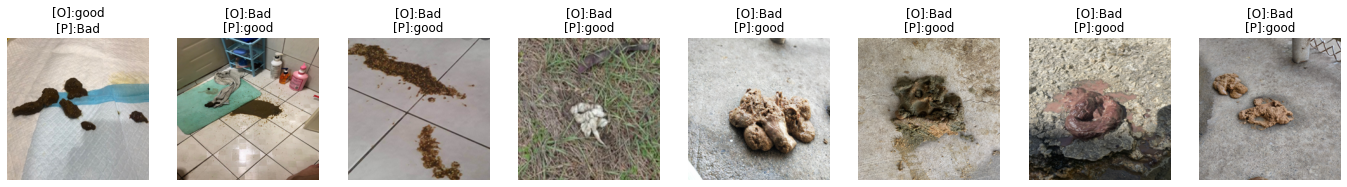

In [ ]:
idx = np.nonzero(pre1 != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre1[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(30, 30))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

In [ ]:



y_pred = np.where(pre > threshold, 1, 0)
print(y_true.shape, y_pred.shape)

In [ ]:
pre = model.predict(preprocess_imgs).argmax(axis=1)

idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(30, 30))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

In [ ]:
y_pred = np.where(pre > threshold, 1, 0)
print(y_true.shape, y_pred.shape)

In [ ]:
# classification_report
print(classification_report(y_true, y_pred))